### This notebook is for testing different initial partitions, and comparing the results. We will select for the rest of the analysis the partition that gives the best results of cross-modularity.

Run the cells of the notebook `01-build-scfc-trees.ipynb` prior to running this notebook.

In [1]:
import numpy as np
from src.connectivity_functions import *
from src.tree_functions import *
from src.ni_functions import *
from src.io_functions import load_data
import os
import json
import matplotlib.pyplot as plt
import seaborn as sns

This code runs the same procedure for every $\gamma$ and every initial parcellation. For each pair, the cross-modularity ($\chi$) is computed and stored in a dataframe, for a level-span from 2 to 120 levels, as the maximum $\chi$ is found in this range.

In [2]:
project_path = "/workspaces/bha2"
conn_sizes = [183, 391, 568, 729, 964, 1242, 1584, 1795, 2165]
gammas_vec = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]

LVLMIN = 2
LVLMAX = 120

df = []
for conn_size in conn_sizes:
    #As in the previous notebook, we load the data and compute the connectome average (or load it if it has been already computed)
    if os.path.exists(
        os.path.join(project_path, "tmp", "n" + str(conn_size) + "_fcm.npy")
    ):
        fcm = np.load(
            os.path.join(project_path, "tmp", "n" + str(conn_size) + "_fcm.npy")
        )
        scm = np.load(
            os.path.join(project_path, "tmp", "n" + str(conn_size) + "_scm.npy")
        )
        print("fcm and scm loaded from tmp folder")
    else:
        sc_group = load_data(
            os.path.join(project_path, "data", "raw", "n" + str(conn_size), "sc")
        )
        fc_group = load_data(
            os.path.join(project_path, "data", "raw", "n" + str(conn_size), "fc")
        )
        fcm, scm = connectome_average(fc_group, sc_group)
        np.save(
            os.path.join(project_path, "tmp", "n" + str(conn_size) + "_fcm.npy"), fcm
        )
        np.save(
            os.path.join(project_path, "tmp", "n" + str(conn_size) + "_scm.npy"), scm
        )
    # We remove the ROIs that have no connections in the structural connectome and the functional connectome
    zero_rows_sc = np.where(~scm.any(axis=1))[0]
    fcm_nonzero, scm_nonzero = remove_rois_from_connectomes(zero_rows_sc, fcm, scm)
    density = np.where(scm_nonzero.flatten() > 0, 1, 0).sum(dtype=float) / (
        len(scm_nonzero.flatten())
    )
    fcm_thr = density_threshold(fcm_nonzero, density)
    zero_rows_fc = np.where(~fcm_thr.any(axis=1))[0]
    fcm_nonzero, scm_nonzero = remove_rois_from_connectomes(
        zero_rows_fc, fcm_thr, scm_nonzero
    )
    # And binarize both connectomes
    fcm_bin = np.where(abs(fcm_nonzero) > 0, 1, 0)
    scm_bin = np.where(scm_nonzero > 0, 1, 0)

    crossmod_gammas = np.empty((LVLMAX - LVLMIN, len(gammas_vec)))
    for g in gammas_vec:
        tree = json.loads(
            open(
                os.path.join(
                    project_path,
                    "data",
                    "processed",
                    "n" + str(conn_size),
                    "tree_g_" + str(g) + ".json",
                )
            ).read()
        )
        # We compute the cross-modularity for each level of the dendrogram and gamma
        crossmod = []
        mod_sc = []
        mod_fc = []
        sim_lvl = []
        for l in range(LVLMIN, LVLMAX):
            level, labels = level_from_tree(tree, l)
            roi_size = []
            for idx, rois in enumerate(level):
                roi_size.append(len(rois))
            T = T_from_level(level)
            sim = np.nanmean(similarity_level(fcm_nonzero, scm_nonzero, level))
            mod_sc_lvl = modularity(scm_nonzero, T)
            mod_fc_lvl = modularity(fcm_nonzero, T)
            c = pow((sim * mod_sc_lvl * mod_fc_lvl), (1 / 3))
            crossmod.append(c)
        crossmod_gammas[:, gammas_vec.index(g)] = crossmod
    # We only store in the dataframe the cross-modularity values for the optimal gamma (the one that maximizes the cross-modularity)
    x, y = np.where(crossmod_gammas == np.nanmax(crossmod_gammas))
    df.append(pd.DataFrame(np.vstack((crossmod_gammas[:, y[0]], 
                        np.array([gammas_vec[y[0]]] * len(crossmod_gammas[:, y[0]])), 
                        np.array([conn_size] * len(crossmod_gammas[:, y[0]])))).T, 
                        columns=["Cross-modularity variability across dendrogram levels", r"$\gamma^*$", "Initial parcellation size (#ROIs)"]))

df = pd.concat(df)
df["Initial parcellation size (#ROIs)"] = df["Initial parcellation size (#ROIs)"].astype(int)

fcm and scm loaded from tmp folder
fcm and scm loaded from tmp folder
fcm and scm loaded from tmp folder
fcm and scm loaded from tmp folder
fcm and scm loaded from tmp folder
fcm and scm loaded from tmp folder
fcm and scm loaded from tmp folder
fcm and scm loaded from tmp folder
fcm and scm loaded from tmp folder


A boxplot is then generated for each $\gamma$ in where the maximum $\chi$ is found ($\gamma^{*}$), and the initial parcellation that gives the best results is selected (in this case the parcellation with #2165 ROIs). The figure is saved in `bha2/data/figures`.

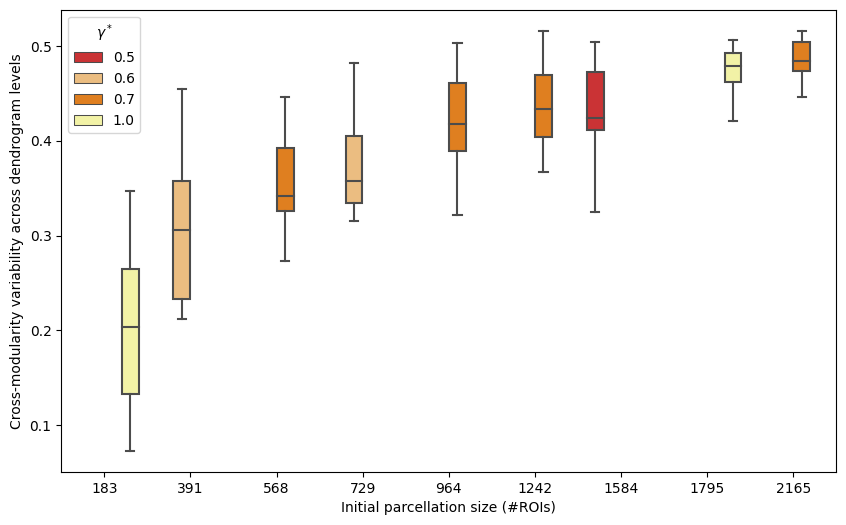

In [21]:
plt.figure(figsize=(10, 6))
max_gammas = np.where(np.in1d(gammas_vec, np.unique(df[r"$\gamma^*$"])))
palette_paired = sns.color_palette("Paired", len(gammas_vec))
palette_max_gammas = [palette_paired[i] for i in max_gammas[0]]
sns.boxplot(x="Initial parcellation size (#ROIs)", y="Cross-modularity variability across dendrogram levels", hue=r"$\gamma^*$", data=df, showfliers=False, palette=palette_max_gammas)
plt.savefig(
    os.path.join(
        project_path, "data", "figures", "initial_parcellation_selection.svg"
    ),
    dpi=300,
    bbox_inches="tight",
    format="svg",
)